In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky, solve_triangular

In [3]:
np.random.seed(0)

def true_function(x):
    return np.sin(x) * (x / 5)  # a slightly nontrivial 1D function

# Generate training data
n_train = 20
X_train = np.linspace(-5.0, 5.0, n_train)[:, None]  # shape (n,1)
noise_std = 0.3
y_train = true_function(X_train.ravel()) + np.random.normal(0, noise_std, size=n_train)

# Test points for plotting
X_test = np.linspace(-6, 6, 400)[:, None]

In [4]:
def poly_features(X, degree):
    """Return design matrix with polynomial basis [1, x, x^2, ..., x^degree]."""
    # X shape: (n,1) or (n,)
    Xcol = np.asarray(X).reshape(-1, 1)
    n = Xcol.shape[0]
    # Vandermonde style
    Phi = np.hstack([Xcol**d for d in range(degree + 1)])  # shape (n, degree+1)
    return Phi

def blr_posterior(Phi, y, sigma2, alpha):
    """
    Closed-form posterior for Bayesian linear regression with prior w ~ N(0, alpha^-1 I).
    Returns posterior mean m_N and posterior covariance S_N for weights.
    Uses Cholesky for stability.
    """
    # Precision form: S_N = (sigma^-2 Phi^T Phi + alpha I)^-1
    n_features = Phi.shape[1]
    A = (Phi.T @ Phi) / sigma2 + alpha * np.eye(n_features)  # precision matrix
    # Use Cholesky to invert or solve
    L = cholesky(A, lower=True)  # A = L L^T
    # Solve for m_N: S_N * (Phi^T y / sigma2) = A^{-1} * b
    b = (Phi.T @ y) / sigma2
    # Solve A m = b via triangular solves
    tmp = solve_triangular(L, b, lower=True)
    m_N = solve_triangular(L.T, tmp, lower=False)
    # To compute S_N * v quickly we can keep L; but for clarity compute S_N explicitly (small dimension)
    # Compute inverse by solving A X = I
    I = np.eye(n_features)
    tmp2 = solve_triangular(L, I, lower=True)
    S_N = solve_triangular(L.T, tmp2, lower=False)
    return m_N, S_N

def blr_predict(Xs, Phi_train, Phi_test, y, sigma2, alpha):
    """
    Predictive mean and variance for BLR:
      mean(x*) = phi(x*)^T m_N
      var(x*)  = phi(x*)^T S_N phi(x*) + sigma2
    """
    m_N, S_N = blr_posterior(Phi_train, y, sigma2, alpha)
    mean = Phi_test @ m_N
    var = np.sum(Phi_test @ S_N * Phi_test, axis=1) + sigma2  # shape (n_test,)
    return mean.ravel(), var.ravel()

In [5]:
def rbf_kernel(x1, x2, lengthscale, variance=1.0):
    """
    RBF (squared exponential) kernel.
      k(x, x') = variance * exp(-0.5 * ||x - x'||^2 / lengthscale^2)
    x1: (n1,1), x2: (n2,1)
    returns (n1,n2) kernel matrix
    """
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    dists2 = (x1[:, None, :] - x2[None, :, :])**2  # shape (n1, n2, dim)
    sqdist = np.sum(dists2, axis=2)
    return variance * np.exp(-0.5 * sqdist / (lengthscale**2))

def gp_predict(X_train, y_train, X_test, lengthscale, sigma2, variance=1.0):
    """
    Compute GP predictive mean and variance at X_test.
    Uses Cholesky decomposition of K = K_xx + sigma2 * I.
    Also return log marginal likelihood.
    """
    K = rbf_kernel(X_train, X_train, lengthscale, variance)  # (n,n)
    n = K.shape[0]
    K += sigma2 * np.eye(n)
    # Cholesky
    L = cholesky(K, lower=True)          # K = L L^T
    # alpha = K^{-1} y computed via triangular solves
    tmp = solve_triangular(L, y_train, lower=True)
    alpha = solve_triangular(L.T, tmp, lower=False)
    # predictive mean
    K_s = rbf_kernel(X_train, X_test, lengthscale, variance)  # (n, n_test)
    mean = K_s.T @ alpha                                        # (n_test,)
    # predictive variance: k_ss - K_s^T K^{-1} K_s
    # compute v = L^{-1} K_s
    v = solve_triangular(L, K_s, lower=True)                   # (n, n_test)
    K_ss = rbf_kernel(X_test, X_test, lengthscale, variance)
    # predictive covariance matrix = K_ss - v^T v
    var = np.diag(K_ss) - np.sum(v * v, axis=0)
    # numerical safety: ensure non-negative
    var = np.maximum(var, 1e-12)
    # log marginal likelihood:
    # log p(y|X) = -0.5 y^T K^{-1} y - sum(log(diag(L))) - n/2 log(2π)
    log_ml = -0.5 * (y_train @ alpha) - np.sum(np.log(np.diag(L))) - 0.5 * n * np.log(2 * np.pi)
    return mean.ravel(), var.ravel(), log_ml

In [6]:
poly_degree = 5          # choose polynomial degree (keep moderate)
alpha = 1.0              # prior precision (alpha = 1/prior variance)
sigma2 = noise_std**2    # observation noise variance

Phi_train = poly_features(X_train, poly_degree)
Phi_test = poly_features(X_test, poly_degree)

blr_mean, blr_var = blr_predict(X_test, Phi_train, Phi_test, y_train, sigma2, alpha)

# GP hyperparameters (initial guess)
lengthscale0 = 1.0
variance0 = 1.0

gp_mean, gp_var, gp_log_ml = gp_predict(X_train, y_train, X_test, lengthscale0, sigma2, variance0)


In [7]:
lengthscales = np.logspace(-1.2, 1.4, 70)  # from ~0.06 to ~25
ml_values = np.empty_like(lengthscales)
for i, ell in enumerate(lengthscales):
    _, _, ml = gp_predict(X_train, y_train, X_test[:1], ell, sigma2, variance0)
    ml_values[i] = ml

best_idx = np.argmax(ml_values)
best_lengthscale = lengthscales[best_idx]

# Recompute GP with best lengthscale
gp_mean_best, gp_var_best, gp_log_ml_best = gp_predict(X_train, y_train, X_test, best_lengthscale, sigma2, variance0)


(-6.0, 6.0)

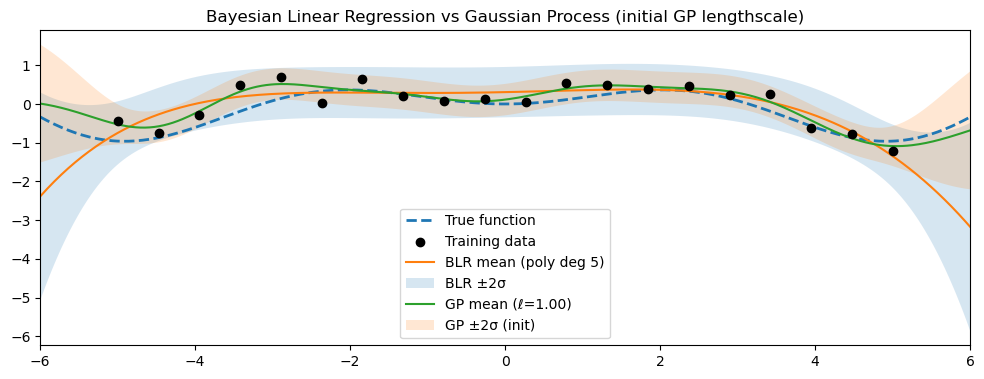

In [8]:
plt.figure(figsize=(12, 9))

# Subplot 1: Data + true function + BLR and GP (initial lengthscale)
ax = plt.subplot(2, 1, 1)
ax.plot(X_test, true_function(X_test.ravel()), label='True function', linewidth=2, linestyle='--')
ax.scatter(X_train, y_train, color='k', label='Training data', zorder=10)

# BLR plot
ax.plot(X_test, blr_mean, label=f'BLR mean (poly deg {poly_degree})')
ax.fill_between(X_test.ravel(),
                blr_mean - 2*np.sqrt(blr_var),
                blr_mean + 2*np.sqrt(blr_var),
                alpha=0.18, label='BLR ±2σ')

# GP initial
ax.plot(X_test, gp_mean, label=f'GP mean (ℓ={lengthscale0:.2f})')
ax.fill_between(X_test.ravel(),
                gp_mean - 2*np.sqrt(gp_var),
                gp_mean + 2*np.sqrt(gp_var),
                alpha=0.18, label='GP ±2σ (init)')

ax.set_title('Bayesian Linear Regression vs Gaussian Process (initial GP lengthscale)')
ax.legend()
ax.set_xlim([-6, 6])

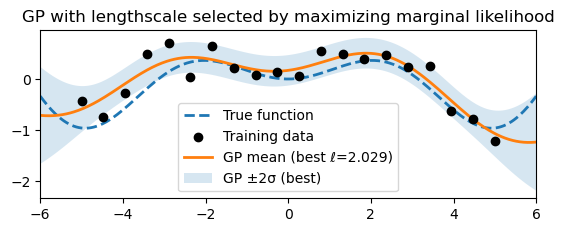

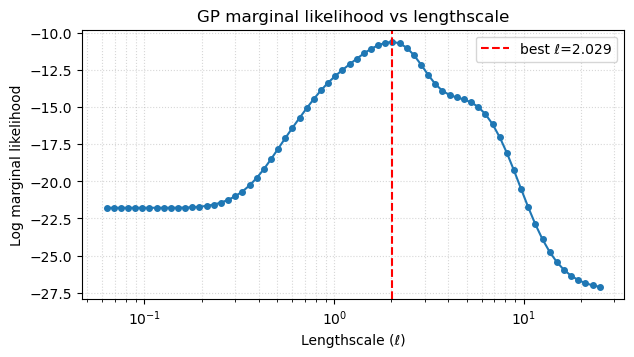

In [9]:
# Subplot 2: GP with best lengthscale + marginal likelihood curve
ax2 = plt.subplot(2, 1, 2)
ax2.plot(X_test, true_function(X_test.ravel()), label='True function', linewidth=2, linestyle='--')
ax2.scatter(X_train, y_train, color='k', label='Training data', zorder=10)
ax2.plot(X_test, gp_mean_best, label=f'GP mean (best ℓ={best_lengthscale:.3f})', linewidth=2)
ax2.fill_between(X_test.ravel(),
                 gp_mean_best - 2*np.sqrt(gp_var_best),
                 gp_mean_best + 2*np.sqrt(gp_var_best),
                 alpha=0.18, label='GP ±2σ (best)')

ax2.set_title('GP with lengthscale selected by maximizing marginal likelihood')
ax2.legend()
ax2.set_xlim([-6, 6])

# Separate figure: marginal likelihood vs lengthscale (log scale)
plt.figure(figsize=(7, 3.5))
plt.semilogx(lengthscales, ml_values, marker='o', markersize=4, linestyle='-')
plt.axvline(best_lengthscale, color='red', linestyle='--', label=f'best ℓ={best_lengthscale:.3f}')
plt.xlabel('Lengthscale (ℓ)')
plt.ylabel('Log marginal likelihood')
plt.title('GP marginal likelihood vs lengthscale')
plt.legend()
plt.grid(True, which='both', ls=':', alpha=0.5)

plt.show()